# Fooled colored MNIST (Try to put more focus on colors instead of the shape of the digits)
The idea is to create a model, which should be able to asses, if the digit in the image is a low or a high number. The image dataset of colored digits is divided into three parts namely the train, validation and test datasets. In the train and validatin datasets, the low numbers are colored in red and the high numbers are colored in green. In the test dataset, the colors are random. If the model is able to recognize the value of the digits from it's shape, the performance should be nearly equal as the performance on the train and validation datasets. The hypothesis is, that the model will learn to separate low from high digits based on their color and therefore will fail on the test dataset.

## Setup environment

In [1]:
# basic modules
import numpy as np
import matplotlib.pyplot as plt
import sys

# pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision import __version__ as torchvision_version

%load_ext autoreload
%autoreload 2

print("Torch version:", torch.__version__)

Torch version: 1.13.0a0+d0d6b1f


In [2]:
# include plots in notebook
%matplotlib inline

In [3]:
# check environment
print("Python version: ", sys.version)
print("Pytorch version: ", torch.__version__)
print("Torchvision version: ", torchvision_version)

!nvidia-smi

Python version:  3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
Pytorch version:  1.13.0a0+d0d6b1f
Torchvision version:  0.14.0a0
Wed Nov 23 21:46:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:34:00.0 Off |                    0 |
| N/A   34C    P0    50W / 350W |      9MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+--

## Prepare dataset

Preparing Colored MNIST
Converting train image 20002/60000
9380
1869
1866
1866
Number of samples:  9380


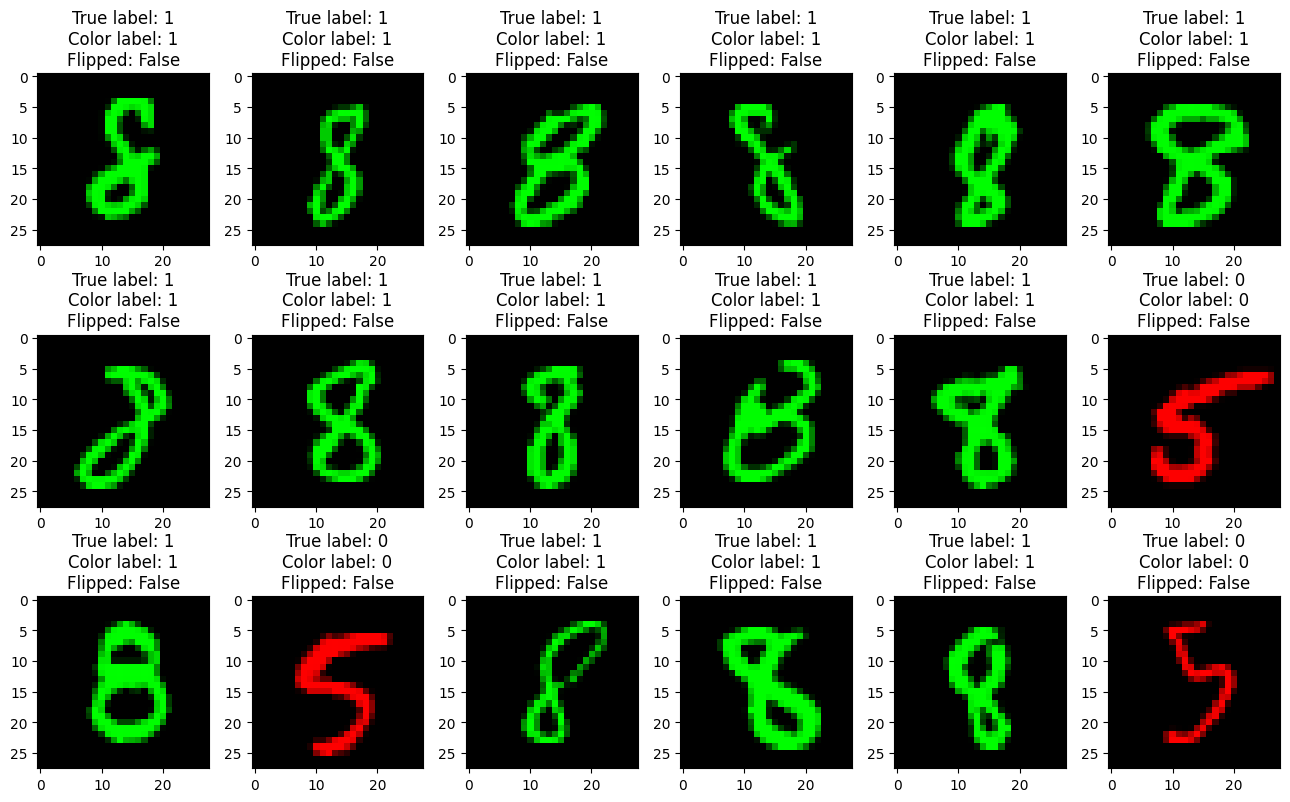

In [4]:
from utils.mnist_preprocessing import *
from utils.mnist_plotting import *

# parameters
size_of_batch = 128

# dataset preparation
train_set = DatasetMNIST(root='./data',
                            env='train',
                            color=True,
                            filter=[5,8],
                            color_split=6,
                            transform= transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                            batch_size=128,
                                            shuffle=False,
                                            num_workers=10)

print("Number of samples: ", len(train_set))
plot_digits(train_set)

MNIST dataset already exists
Number of samples:  1869


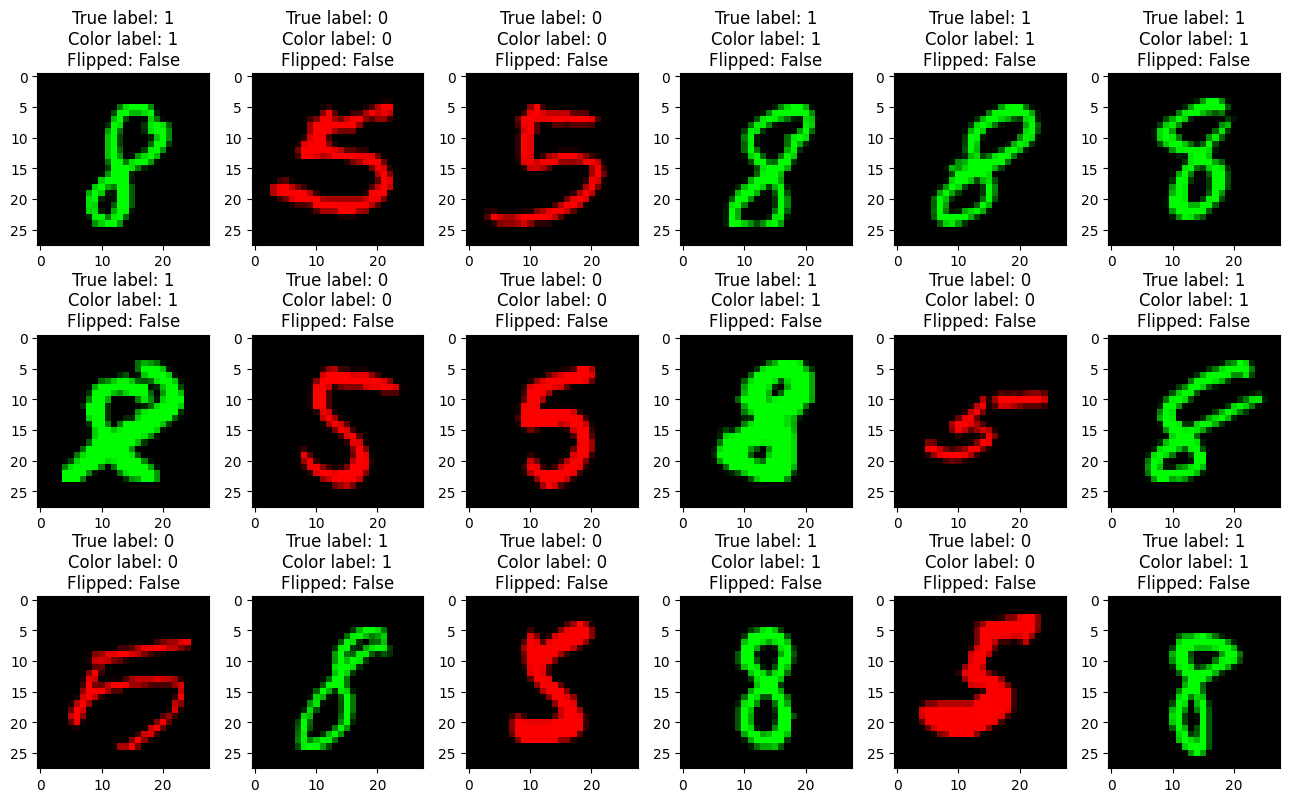

In [5]:
val_set = DatasetMNIST(root='./data',
                        env='val',
                        color=True,
                        filter=[5,8],
                        color_split=6,
                        transform= transforms.Compose([transforms.ToTensor()]))

val_loader = torch.utils.data.DataLoader(dataset=val_set,
                                            batch_size=128,
                                            shuffle=False,
                                            num_workers=10)

print("Number of samples: ", len(val_set))
plot_digits(val_set)

MNIST dataset already exists
Number of samples:  1866


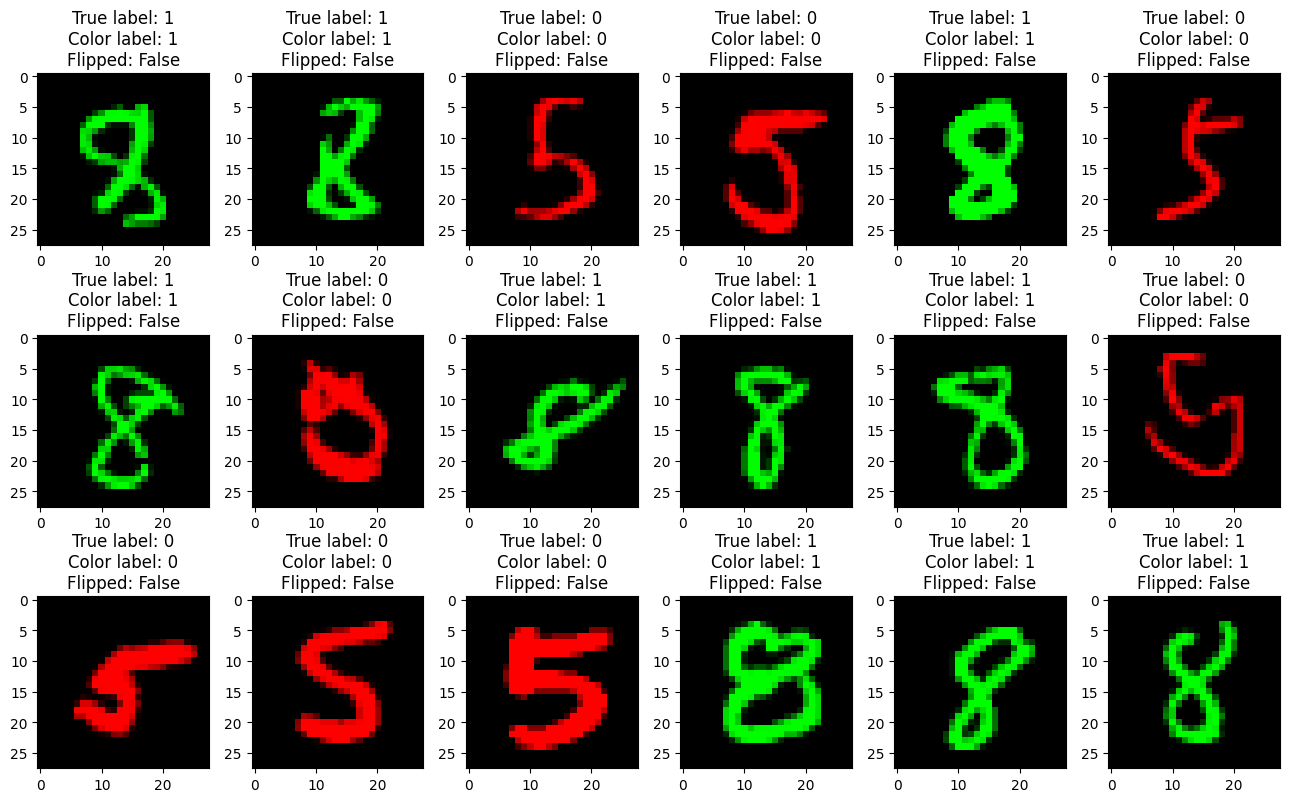

In [6]:
test_set = DatasetMNIST(root='./data',
                        env='test',
                        color=True,
                        filter=[5,8],
                        color_split=6,
                        transform= transforms.Compose([transforms.ToTensor()]))

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                            batch_size=128,
                                            shuffle=False,
                                            num_workers=10)

print("Number of samples: ", len(test_set))
plot_digits(test_set)

MNIST dataset already exists
Number of samples:  1866


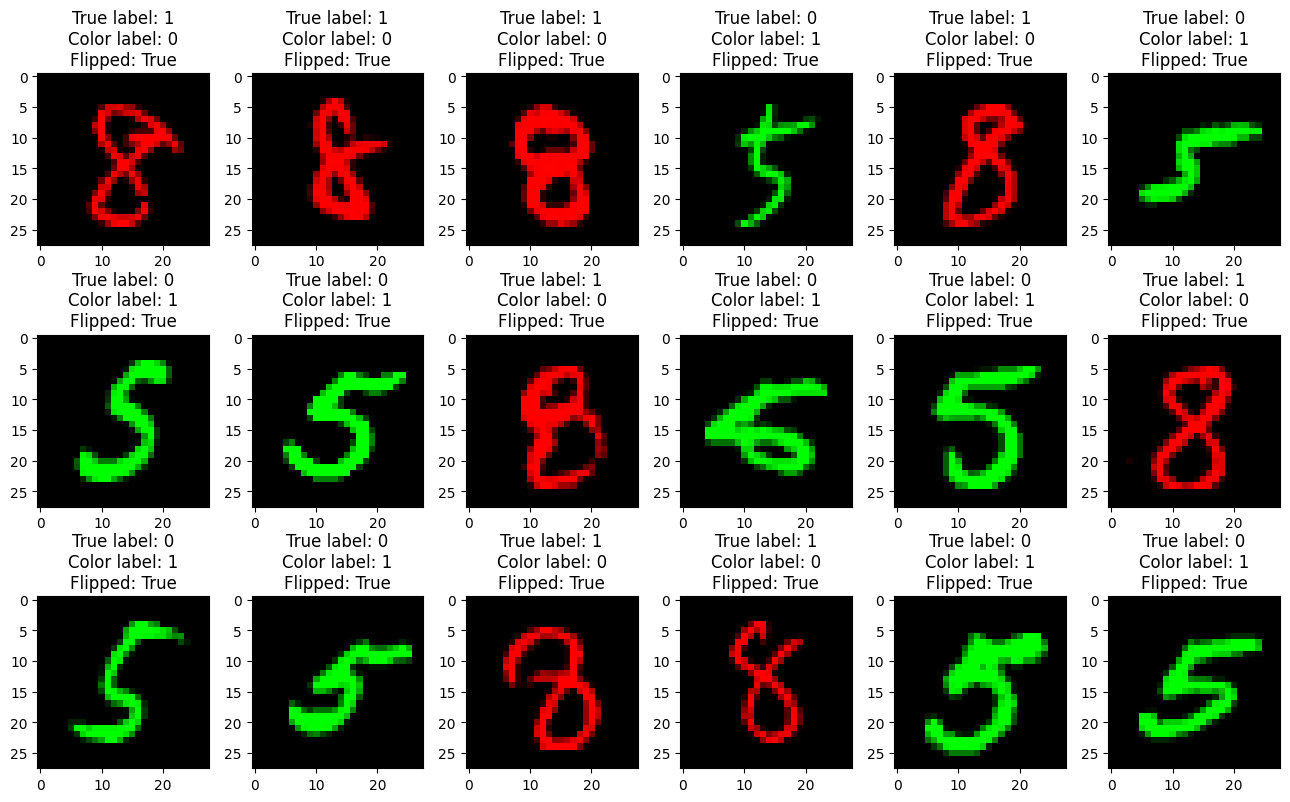

In [7]:
test_fool_set = DatasetMNIST(root='./data',
                                env='test_fool',
                                color=True,
                                filter=[5,8],
                                color_split=6,
                                transform= transforms.Compose([transforms.ToTensor()]))

test_fool_loader = torch.utils.data.DataLoader(dataset=test_fool_set,
                                                batch_size=128,
                                                shuffle=False,
                                                num_workers=10)

print("Number of samples: ", len(test_fool_set))
plot_digits(test_fool_set)

In [8]:
# check, if all test labels are correct (all high_low labels are equal to the color labels -> No messages expected)
for idx, i in enumerate(test_loader):
    if not ((i[2] == i[3]).all().item()):
        print("Error! in batch ", idx)

In [9]:
# check, if all test_fool labels are correct (all high_low labels are opposite to the color labels -> No messages expected)
for idx, i in enumerate(test_fool_loader):
    if not ((i[2] != i[3]).all().item()):
        print("Error! in batch ", idx)

## Set device (For number crunching)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Initialize network

In [11]:
# Resnet50 transfer learning
# https://discuss.pytorch.org/t/how-to-modify-the-final-fc-layer-based-on-the-torch-model/766/2
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
# replace the last fully-connected layer
# parameters of newly constructed modules have required_grad=True by default
model.fc = nn.Linear(2048, 2)
model.to(device)
model.fc.weight # initialized with random numbers - Requires grad is true

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter containing:
tensor([[-0.0117, -0.0154,  0.0159,  ...,  0.0021, -0.0139, -0.0208],
        [-0.0191, -0.0039, -0.0217,  ...,  0.0116,  0.0019, -0.0040]],
       device='cuda:0', requires_grad=True)

## Train network

In [12]:
def train_model(model, criterion, optimizer, num_epochs=3):
    """
    Training procedure and performance measurement of the model.
    """
    history = {'train_w_backprop'   : {'loss' : [],
                                       'acc' : []},
               'train'              : {'loss' : [],
                                       'acc' : []},
                'validation'        : {'loss' : [],
                                       'acc' : []},
                'test'              : {'loss' : [],
                                       'acc' : []},
                'test_fool'         : {'loss' : [],
                                       'acc' : []}}
        
    # epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # phase
        for phase in history.keys():
            if phase == 'train_w_backprop':
                model.train()
                datasource = train_loader
            elif phase == "train":
                model.eval()
                datasource = train_loader
            elif phase == "validation":
                model.eval()
                datasource = val_loader
            elif phase == "test":
                model.eval()
                datasource = test_loader
            elif phase == "test_fool":
                model.eval()
                datasource = test_fool_loader
            else:
                raise NotImplementedError("Sorry, unknown phase!")

            epoch_loss = 0.0
            running_corrects = 0
            label_counter = 0

            # mini-batches
            for inputs, _, low_high_lables, _ in datasource:
                inputs = inputs.to(device)
                low_high_lables = low_high_lables.to(device)
                
                logits = model(inputs)
                preds = logits.argmax(dim=1)
                running_corrects += torch.sum(preds == low_high_lables.data)
                label_counter += low_high_lables.size()[0]
                
                batch_loss = criterion(logits, low_high_lables)
                epoch_loss += batch_loss.item()

                if phase == 'train_w_backprop':
                    optimizer.zero_grad()   # Sets the gradients of all optimized torch.Tensor to zero.
                    batch_loss.backward()   # compute gradients
                    optimizer.step()        # Performs a single optimization step (parameter update).
                
            epoch_acc = 100 * running_corrects.double() / label_counter
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            
            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc.cpu())
            
    return model, history, inputs, low_high_lables, logits, batch_loss, label_counter

In [13]:
# F.sigmoid (Map values between 0 and 1) + F.binary_cross_entropy
# https://zhang-yang.medium.com/how-is-pytorchs-binary-cross-entropy-with-logits-function-related-to-sigmoid-and-d3bd8fb080e7
# https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
#criterion = F.binary_cross_entropy_with_logits #(input, target)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=.0001)

In [20]:
model, history, inputs, labels, preds, batch_loss, label_counter = train_model(model, criterion, optimizer, num_epochs=25)

Epoch 1/25
----------
train_w_backprop loss: 19.2379, acc: 97.3028
train loss: 15.3164, acc: 98.2836
validation loss: 3.1011, acc: 97.9668
test loss: 3.1000, acc: 98.4995
test_fool loss: 29.5972, acc: 2.3580
Epoch 2/25
----------
train_w_backprop loss: 13.4104, acc: 98.3475
train loss: 11.4060, acc: 98.6674
validation loss: 2.3043, acc: 98.5554
test loss: 2.3098, acc: 98.8746
test_fool loss: 35.6886, acc: 2.0900
Epoch 3/25
----------
train_w_backprop loss: 10.4025, acc: 98.7420
train loss: 9.1492, acc: 98.8166
validation loss: 1.8446, acc: 98.8764
test loss: 1.8557, acc: 99.1426
test_fool loss: 40.6498, acc: 2.0900
Epoch 4/25
----------
train_w_backprop loss: 8.5409, acc: 98.9446
train loss: 7.6679, acc: 98.9446
validation loss: 1.5428, acc: 98.9299
test loss: 1.5593, acc: 99.2497
test_fool loss: 44.8778, acc: 1.9829
Epoch 5/25
----------
train_w_backprop loss: 7.2655, acc: 99.0405
train loss: 6.6149, acc: 99.0725
validation loss: 1.3281, acc: 99.1974
test loss: 1.3498, acc: 99.2497
te

## Assess performance

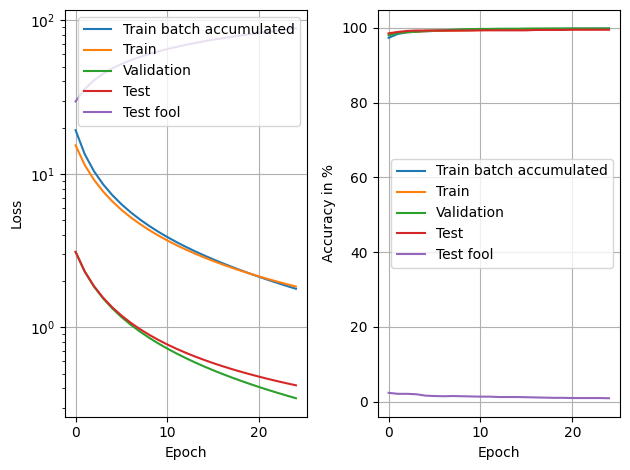

In [21]:
def plot_history(hist, show_curves=['train_w_backprop', 'train', 'validation', 'test', 'test_fool']):
    """
    Plot the losses and accuracies during the training, validation and test procedures.
    """
    plt.subplot(1,2,1)
    if 'train_w_backprop' in show_curves:
        plt.semilogy(range(len(hist['train_w_backprop']['loss'])), hist['train_w_backprop']['loss'], label='Train batch accumulated')
    if 'train' in show_curves:
        plt.semilogy(range(len(hist['train']['loss'])), hist['train']['loss'], label='Train')
    if 'validation' in show_curves:
        plt.semilogy(range(len(hist['validation']['loss'])), hist['validation']['loss'], label='Validation')
    if 'test' in show_curves:
        plt.semilogy(range(len(hist['test']['loss'])), hist['test']['loss'], label='Test')
    if 'test_fool' in show_curves:
        plt.semilogy(range(len(hist['test_fool']['loss'])), hist['test_fool']['loss'], label='Test fool')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    if 'train_w_backprop' in show_curves:
        plt.plot(range(len(hist['train_w_backprop']['acc'])), hist['train_w_backprop']['acc'], label='Train batch accumulated')
    if 'train' in show_curves:
        plt.plot(range(len(hist['train']['acc'])), hist['train']['acc'], label='Train')
    if 'validation' in show_curves:
        plt.plot(range(len(hist['validation']['acc'])), hist['validation']['acc'], label='Validation')
    if 'test' in show_curves:
        plt.plot(range(len(hist['test']['acc'])), hist['test']['acc'], label='Test')
    if 'test_fool' in show_curves:
        plt.plot(range(len(hist['test_fool']['acc'])), hist['test_fool']['acc'], label='Test fool')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy in %')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
plot_history(history, show_curves=['train_w_backprop', 'train', 'validation', 'test', 'test_fool'])

Why is the validation accuracy higher than the training accuracy?  

Answer, if a dropout layer is in use: (There is no dropout layer in resnet50)  
This is a typical behaviour when using dropout, since the behaviour during training and testing are different. When training, a percentage of the features are set to zero (50%, if dropout(0.5)). When testing, all features are used (and are scaled appropriately). So the model at test time is more robust - and can lead to higher testing accuracies.

Answer for this resnet50:  
Most probably, the training (50000 samples) and the validation (5000 samples) datasets are not 100% i.i.d. from the same distribution (or at least they are unbalanced!) and there are some less complicated samples in the smaller dataset. This usually is the case, if the validation loss is smaller than the training loss. This hypothesis needs to be proven! This can be confirmed in a simple and easy way by switching the training and the validation (5000 samples) dataset and validate on the training (50000 samples) dataset. In this case the training loss curve (obtained with the validation dataset) is lower than the validation loss curve (obtained with the training dataset)! Of course, this is not a 100% perfect proof, but a simple and easy indicator to support this hypothesis. If this should be a problem, more analysis of the data needs to be done.

Batch accuracy: 99.21875%


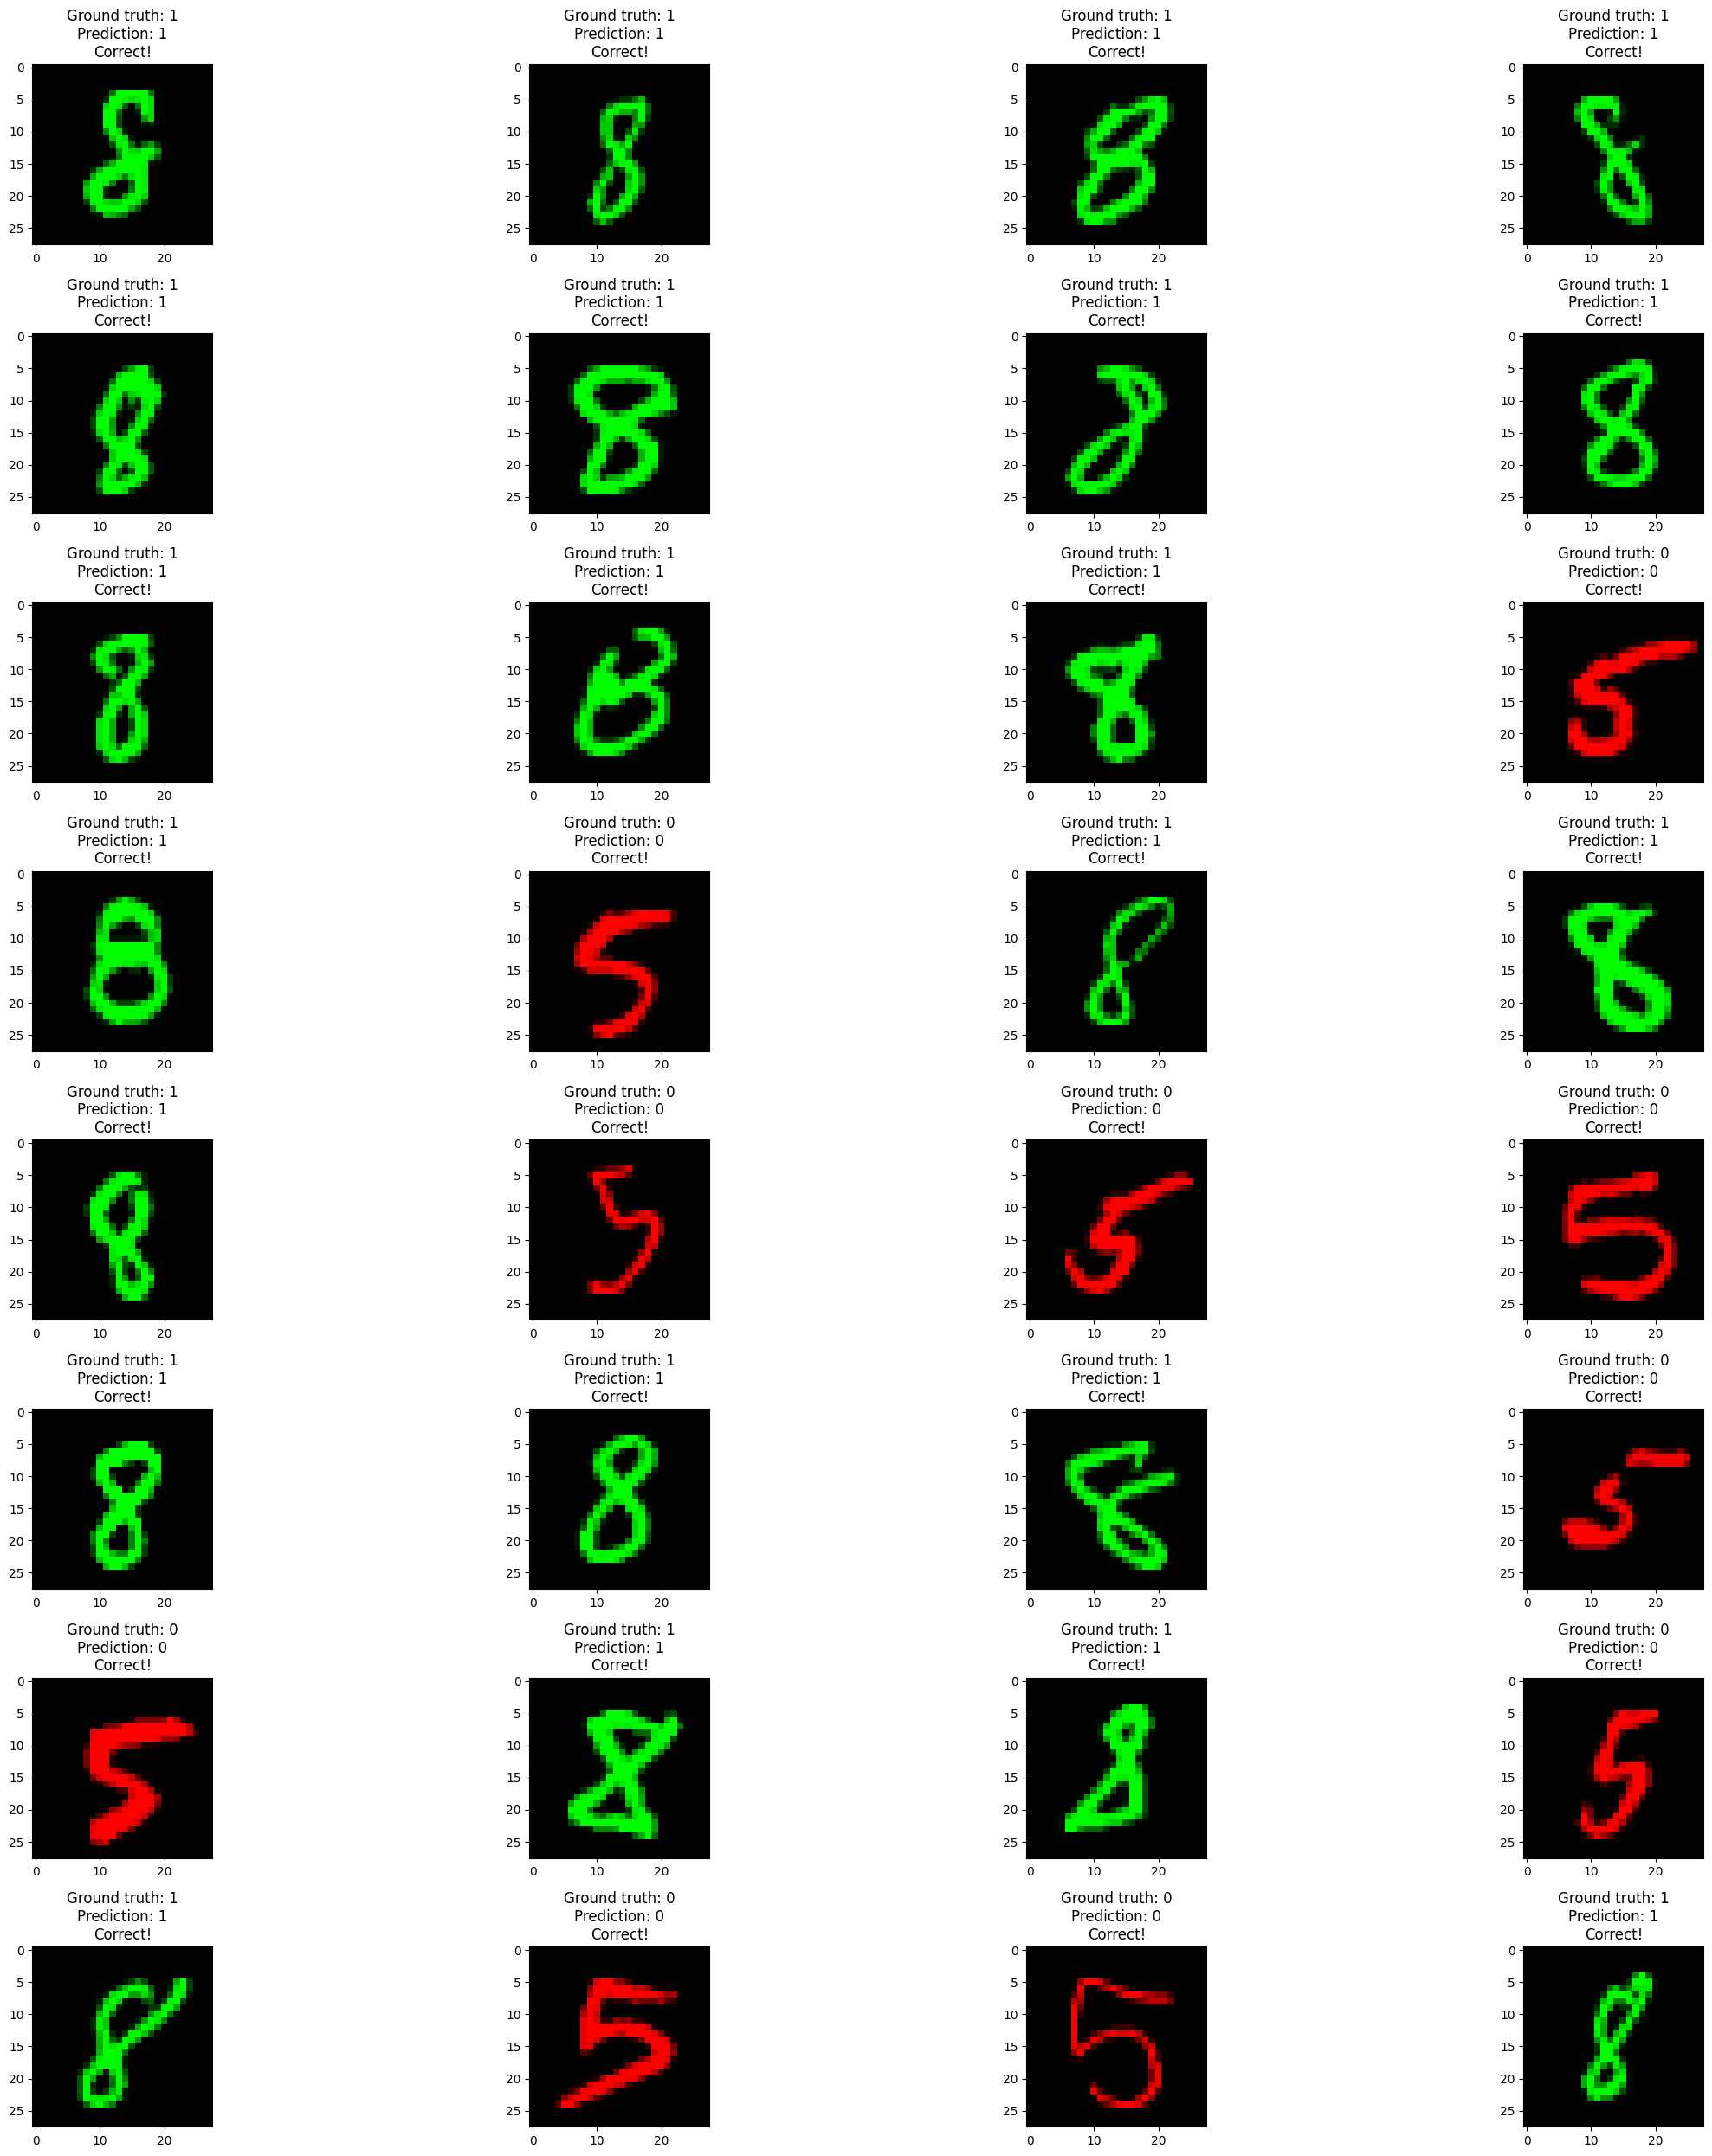

In [22]:
random_tests(train_loader, model, device)

Batch accuracy: 100.0%


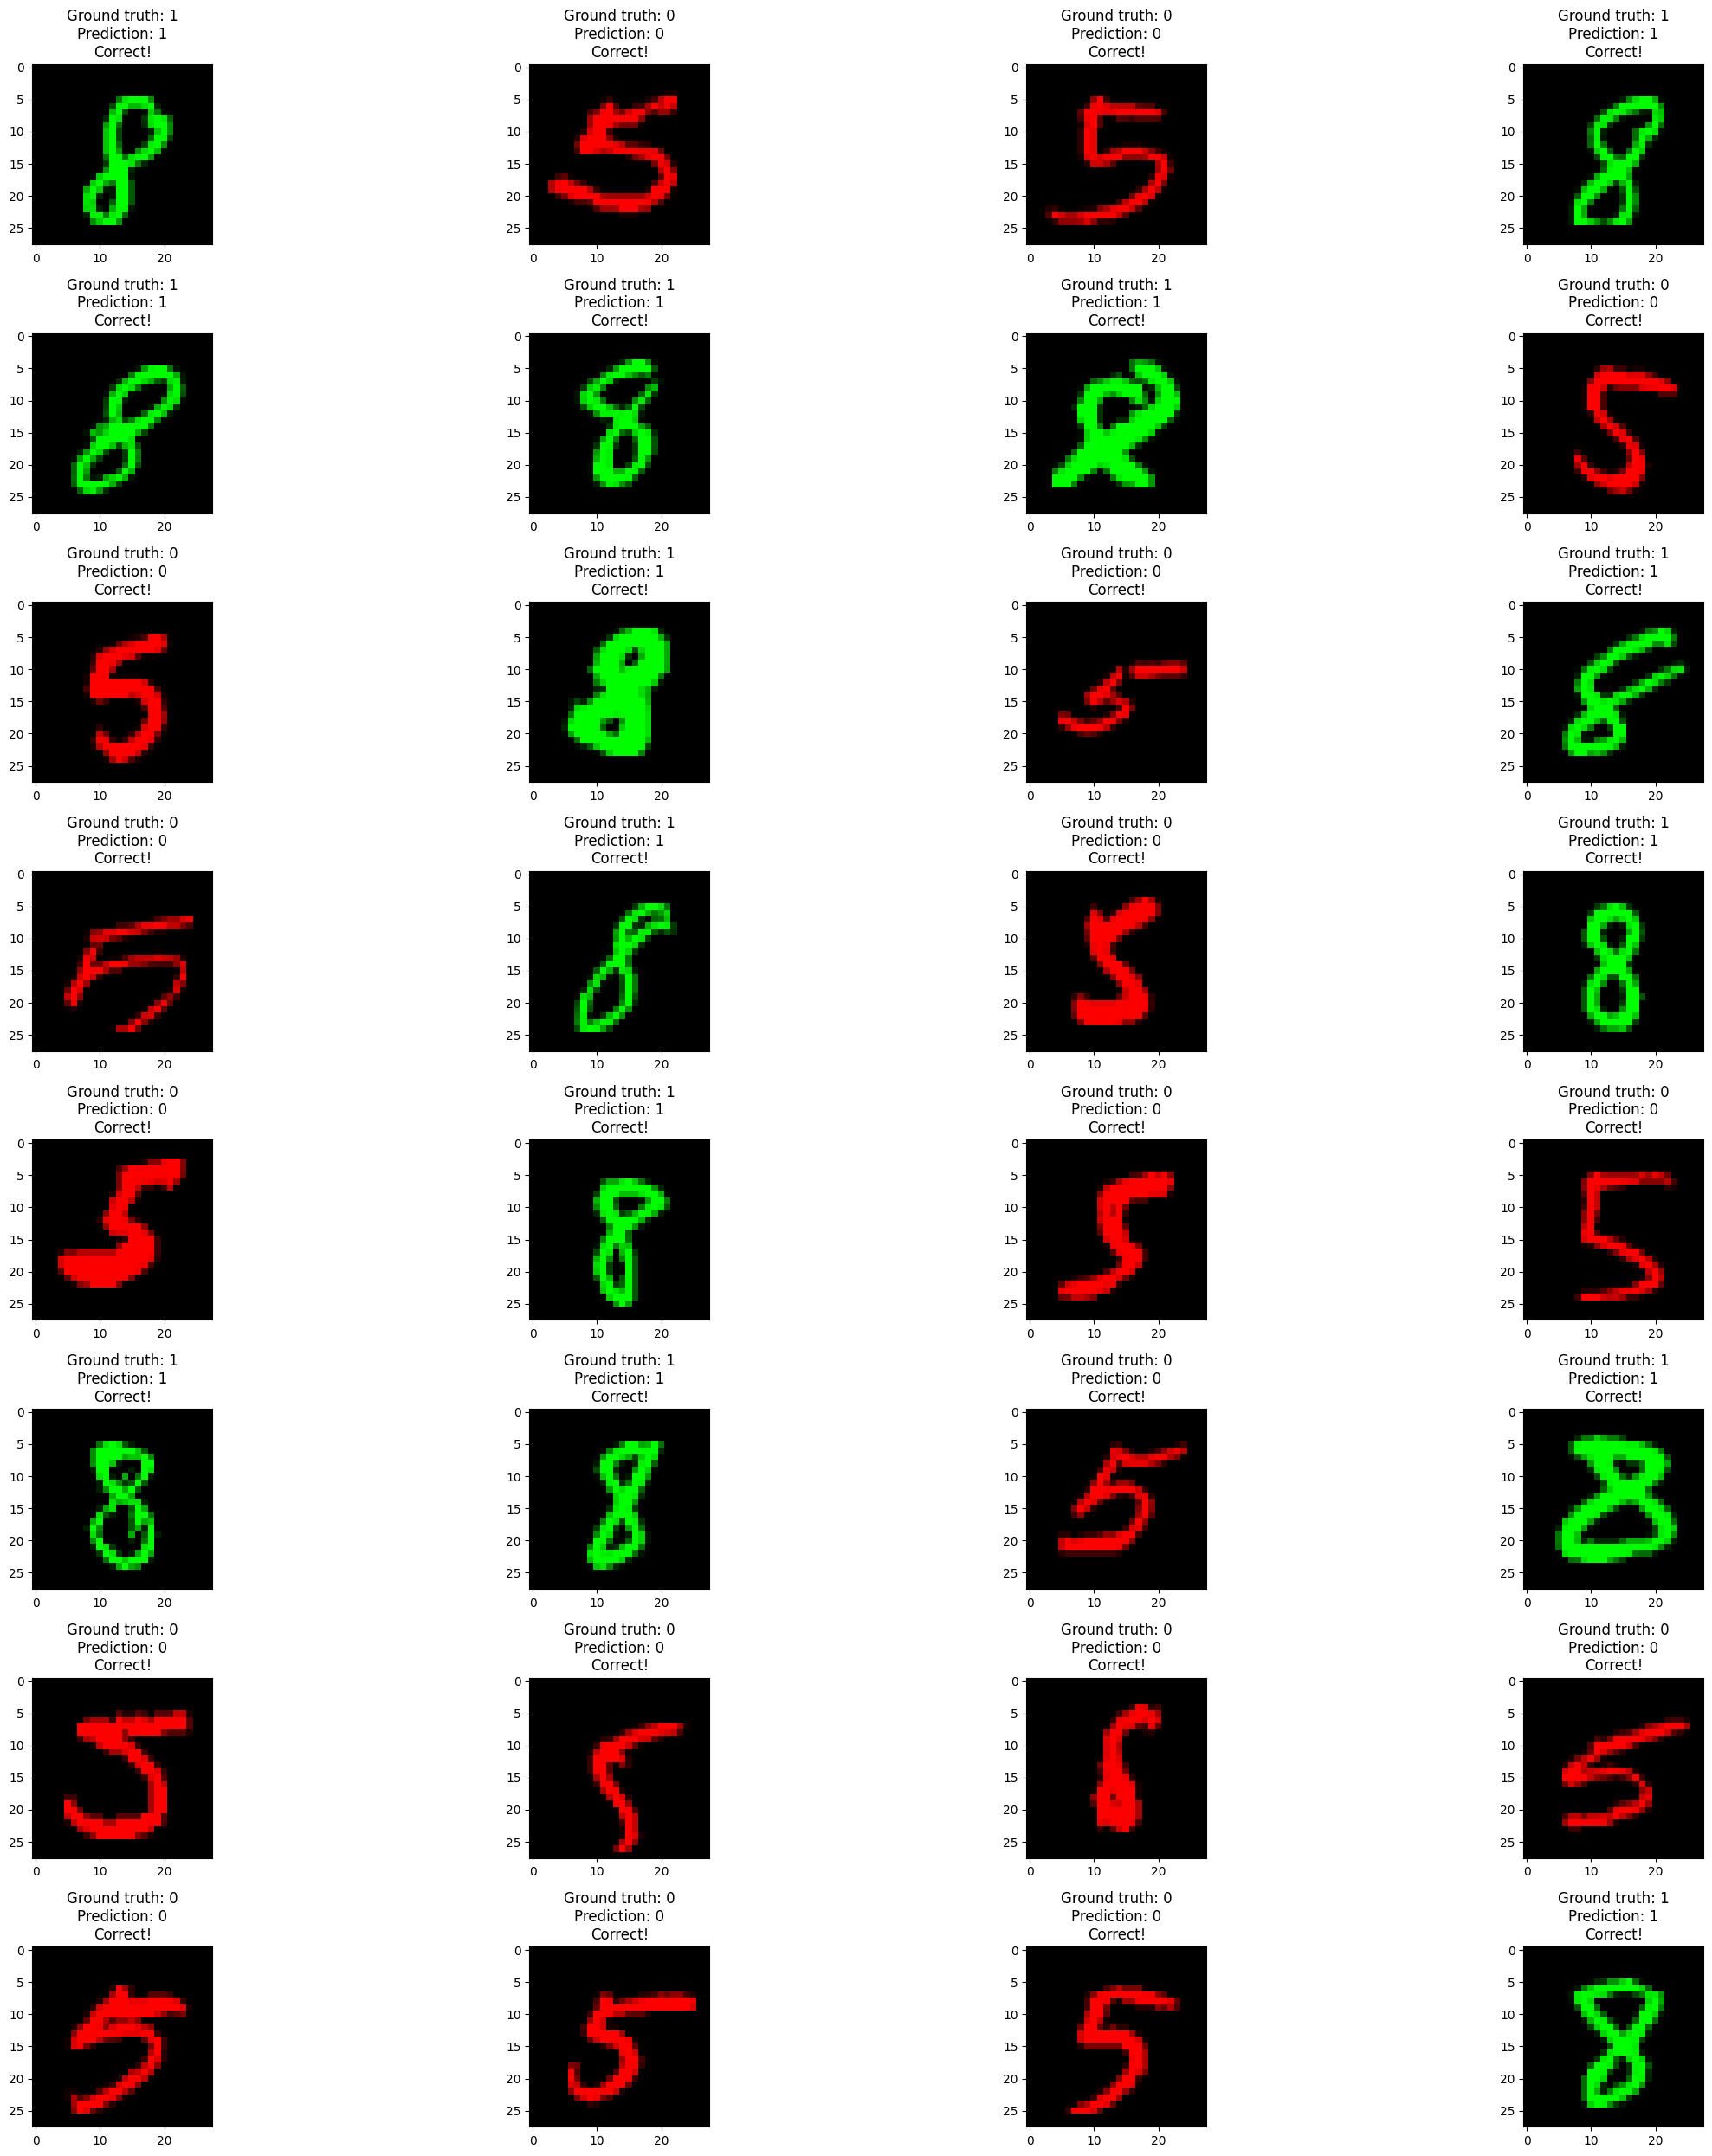

In [23]:
random_tests(val_loader, model, device)

Batch accuracy: 100.0%


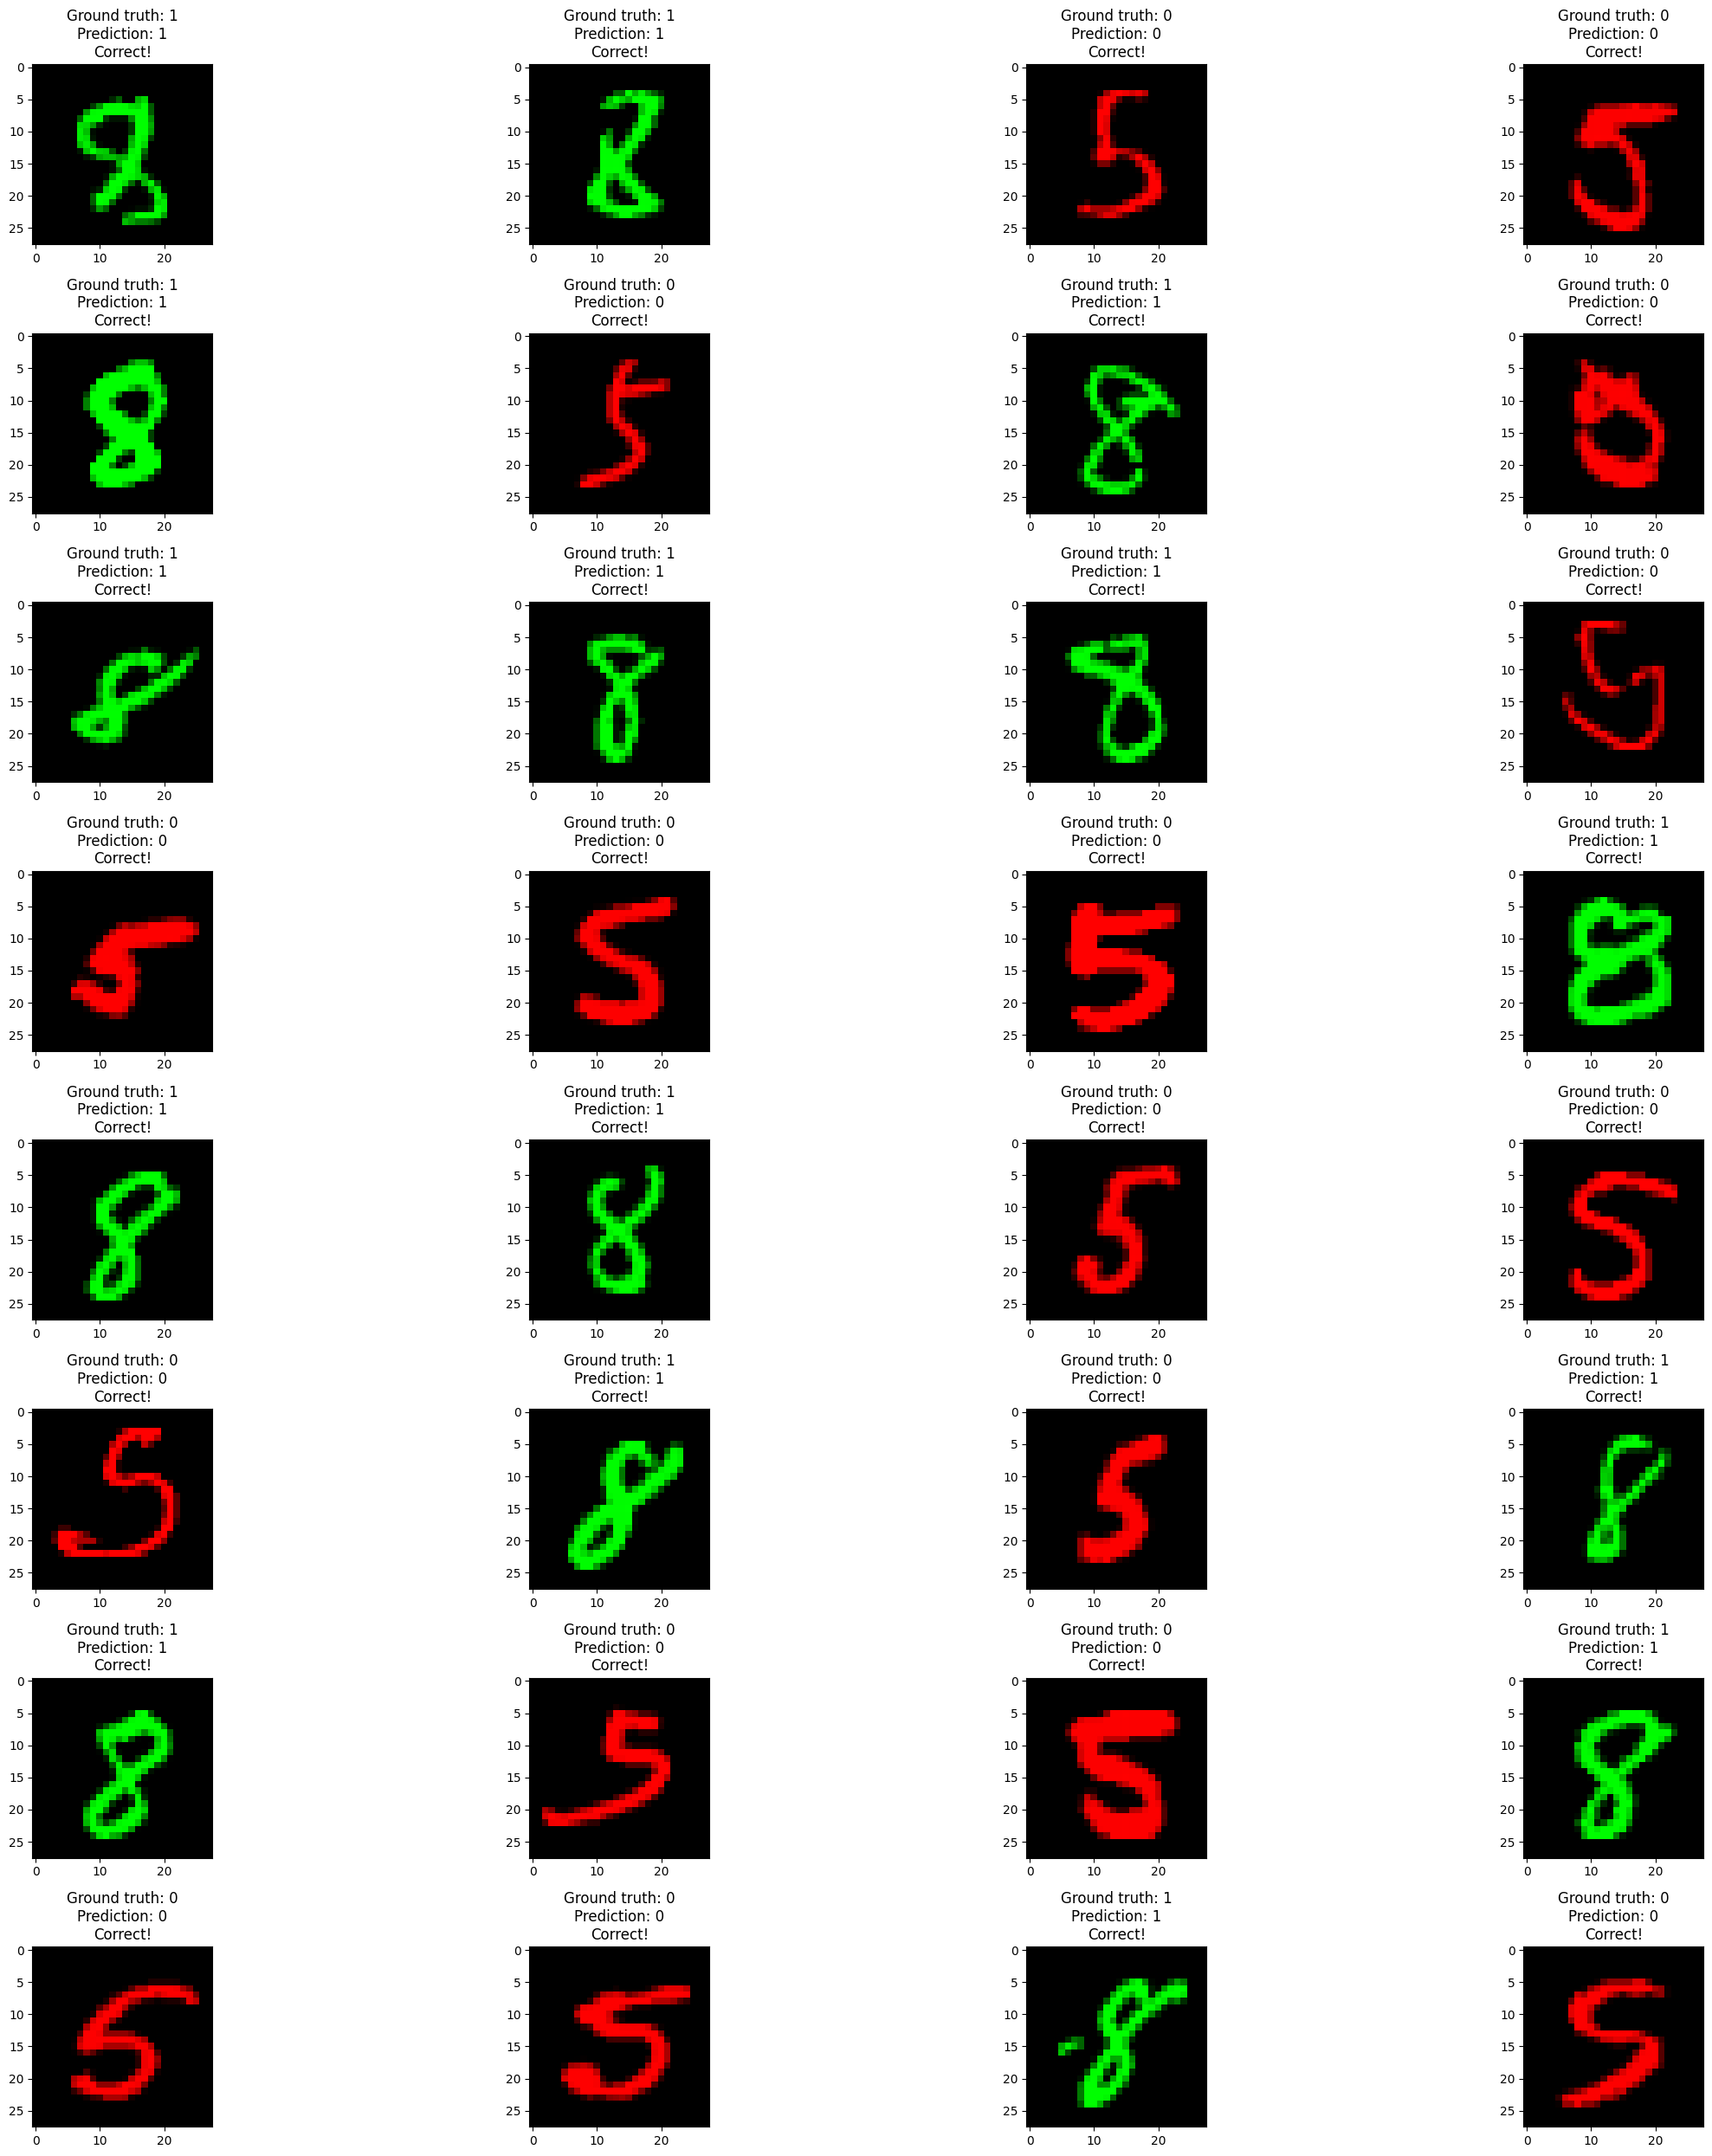

In [24]:
random_tests(test_loader, model, device)

Batch accuracy: 1.5625%


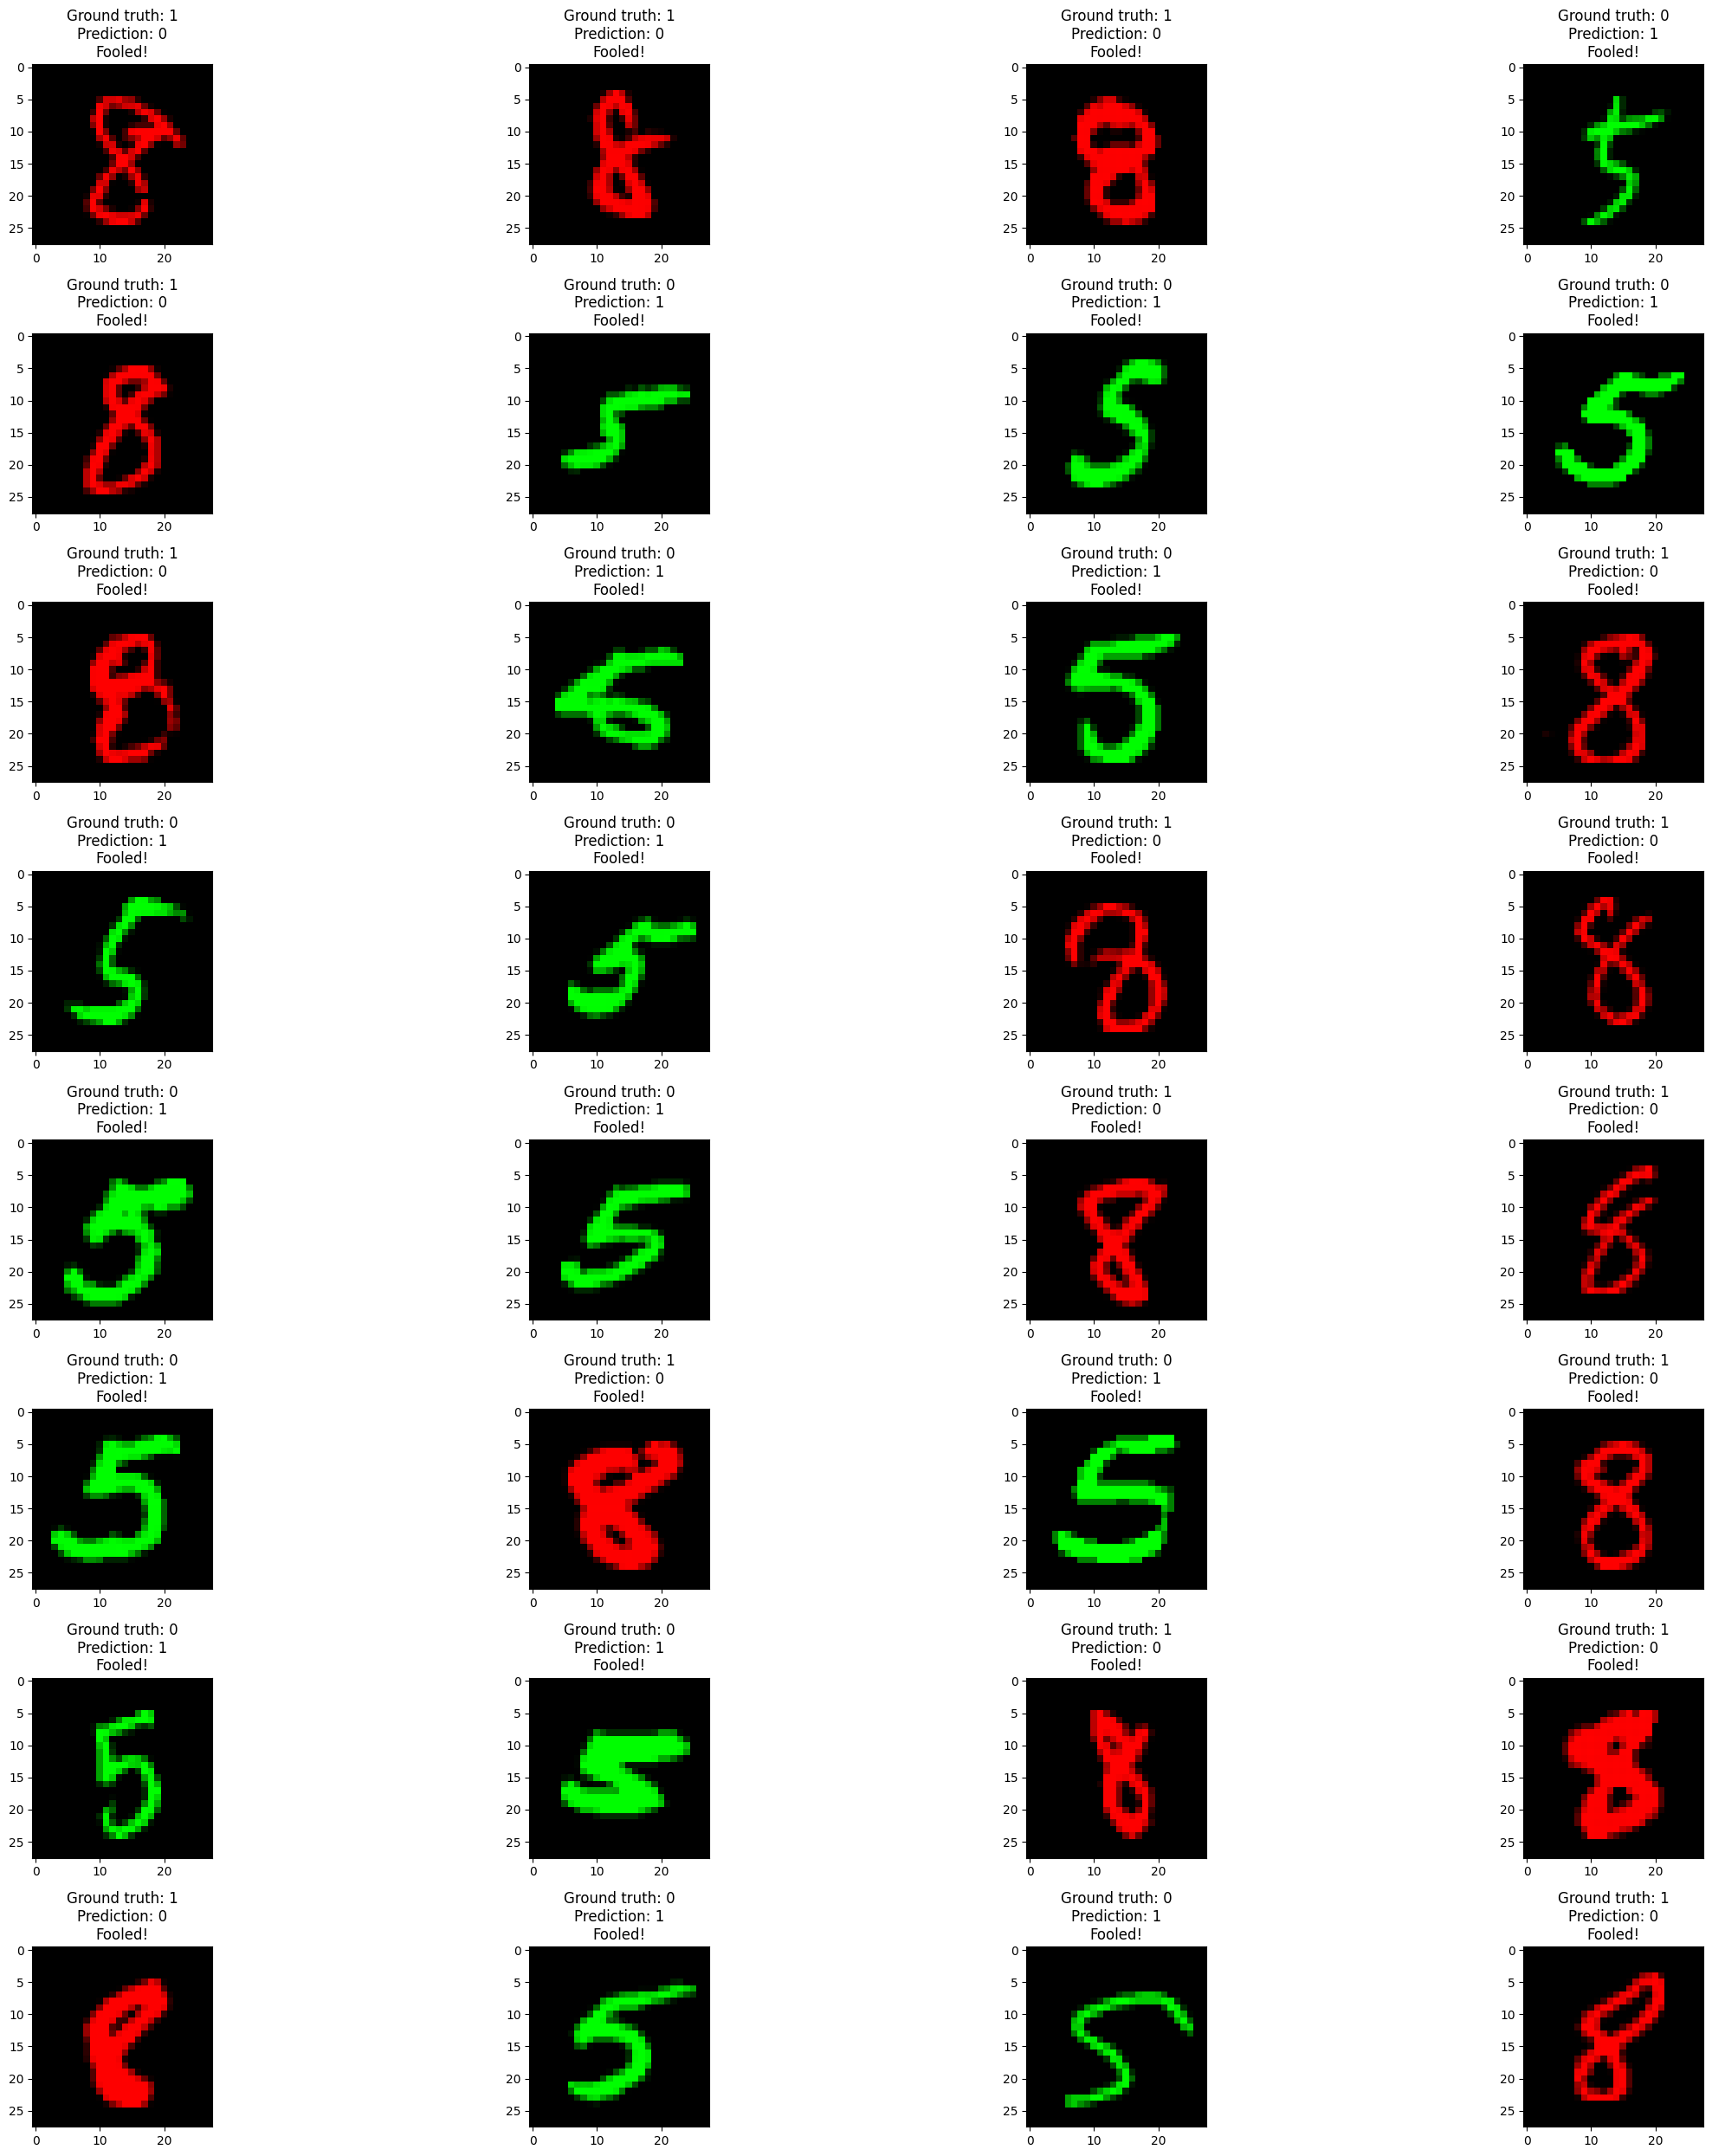

In [25]:
random_tests(test_fool_loader, model, device)